### Get uncorrected bigwigs

In [1]:
import pyBigWig
import pandas as pd
import numpy as np
from load_model import *
import os
import pyfaidx
import one_hot
os.environ["CUDA_VISIBLE_DEVICES"]="3"


reference_genome_path="/mnt/data/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
reader = pyfaidx.Fasta(reference_genome_path)

#ATAC
gc_matched_negs = "/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet_sept_09/GM12878/negatives_data/bpnet.inputs.all.negatives.bed"
#gc_matched_negs = "/srv/scratch/anusri/chrombpnet_paper/GM12878/DNASE_negatives_data/bpnet.inputs.all.negatives.bed"
neg_bed=pd.read_csv(gc_matched_negs,delimiter="\t", names=["chr", "start", "end", "name", "score", "strand", "pval", "qval", "qval2", "summit"])
neg_bed.head()

#peak_bed_file = "/oak/stanford/groups/akundaje/projects/atlas/atac/caper_out/5846e593-a935-4bd9-9294-422a05f9f9b8/call-reproducibility_idr/glob-1b1244d5baf1a7d98d4b7b76d79e43bf/idr.optimal_peak.narrowPeak.gz"
#peak_bed=pd.read_csv(peak_bed_file,delimiter="\t", names=["chr", "start", "end", "name", "score", "strand", "pval", "qval", "qval2", "summit"])


#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/ATAC_07.22.2021/bias_fit_on_signal_step2/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/ATAC_07.22.2021/final_model_step3_new/"

#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/ATAC_07.22.2021/final_model_step3_new/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/tobias_scripts/GM12878/tobias_ATAC_08.03.2021/final_model/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/hint_atac_scripts/GM12878/hintatac_ATAC_07.27.2021/model/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/4_5_shifted_ATAC_07.28.2021/final_model_step3_new/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/4_4_model/final_model_step3_new/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/4_5_shifted_ATAC_07.28.2021/bias_fit_on_signal_step2/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/4_4_model/final_model_step3_new/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/DNASE_08.11.2021/final_model_step3_new/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/DNASE_08.11.2021/bias_fit_on_signal_step2/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/DNASE_08.11.2021/final_model_step3_new/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/hintatac_DNASE_08.12.2021/model/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/ATAC_07.22.2021/with_HEPG2_bias_final_model/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/ATAC_07.22.2021/final_model_step3_new_skip_step2/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/ATAC_07.22.2021/with_H1_bias_final_model/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/H1/ATAC_07.22.2021/with_gm12878_bias_final_model/unplug/"
path="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet_sept_09/GM12878/ATAC_07.22.2021/final_model_step3_new/unplug/"
#path= "/oak/stanford/groups/akundaje/anusri/bias_data/gm12878_invivo_bias_model/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/4_4_shifted_ATAC_08.19.2021_bias_filters_250/final_model_step3_new/unplug/"
#path="/srv/scratch/anusri/chrombpnet_paper/GM12878/4_4_shifted_ATAC_08.19.2021_bias_filters_100/final_model_step3_new/unplug/"

try:
    model=load_model_wrapper(model_hdf5=path+"model.0.hdf5")
except:
    model=load_model_wrapper(json_string=path+"model.0.arch", weights=path+"model.0.weights")
output_file="hintatac_tn5_motif2.pkl"

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 2114, 4)]    0                                            
__________________________________________________________________________________________________
1st_conv (Conv1D)               (None, 2094, 500)    42500       sequence[0][0]                   
__________________________________________________________________________________________________
0_non_dil-crop_1th_dconv (Cropp (None, 2090, 500)    0           1st_conv[0][0]                   
__________________________________________________________________________________________________
1_dilconv (Conv1D)              (None, 2090, 500)    750500      1st_conv[0][0]                   
_______________________________________________________________________________________

In [2]:
test_nonpeaks = neg_bed[(neg_bed["chr"]=="chr1")]
#test_inpeaks = peak_bed[(peak_bed["chr"]=="chr1")]



In [3]:
def get_seq(genome, peaks_df, width=2114):
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)]))
        
    return one_hot.dna_to_one_hot(vals)


def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [4]:
test_nonpeaks_seqs = get_seq(reader, test_nonpeaks)



In [5]:
#def profiles_predictions(seqs, model_peaks_corrected):
#    random.shuffle(seqs)
#    
#    w_mot_seqs = seqs.copy()[0:100]
#    
#    predictions = []
#    
#    for i in range(0,100,20):
#        unplug_bias_pred = softmax(model_peaks_corrected.predict([w_mot_seqs[i:i+20]], 
#                                                                       verbose=True)[0])
#        predictions.extend(unplug_bias_pred)
#    
#    return predictions

#print(corrected_model.inputs)

#predictions = profiles_predictions(test_inpeaks_seqs, corrected_model)

#predictions = np.array(predictions).reshape(100,1000)

#import matplotlib.pyplot as plt
#plt.plot(predictions[0,:])



In [6]:
import random
random.seed(1)

num=17851
#num=100
    
def profiles_for_motif(seqs, motif, model_peaks_corrected):
    random.shuffle(seqs)
  
    w_mot_seqs = seqs.copy()[0:num]
    w_mot_seqs[:, 1057:1057+len(motif)] = one_hot.dna_to_one_hot([motif])
    
    predictions = []
    
    for i in range(0,num,100):
        unplug_bias_pred = softmax(model_peaks_corrected.predict([w_mot_seqs[i:i+100]], 
                                                                       verbose=True)[0])
        predictions.extend(unplug_bias_pred)
    
    return predictions

In [7]:
#Tn5
import matplotlib.pyplot as plt

#motifs_to_test = ["GCACAGTACAGAGCTG", "GTGCACAGTTCTAGAGTGTGCAG", "CCTCTACACTGTGCAGAA", "GCACAGTTCTAGACTGTGCAG", "CTGCACAGTGTAGAGTTGTGC"]
#Tn5

#motifs_to_test = ["TTTACAAGTCCA", "TGTACTTACGAA"]
#DNASE

motifs_to_test = ["GCGCATGCGC", "CGATATGACTCATCCC", "TTGGCCACTAGGGGGCGCTAT", "CCGAAAGCGGAAGTGAGAC"]
#NRF1, AP1, CTCF, ETS

#motifs_to_test = ["ATAGCGCCCCCTAGTGGCCAA", "TTGGCCACTAGGGGGCGCTAT"]
#motifs_to_test = ["CCATTGTTATGCAAAT"]

#motifs_to_test = ["AAGGGGGCGGGGCCTAA", "CCCTAACCACAGCCC", "GCAAGGGAAATTCCCCAGG", "GATAAG"]
#SPI1, RUNX, NFKB, GATA1

motifs_to_test = ["CCCTAACCACAGCCC", "GCAAGGGAAATTCCCCAGG", "GACAGATAAGGCG", "CCGGGTCCAAAGTCCACCGG"]
#GM12878
predictions_motifs = []
for motif in motifs_to_test:
    pred_unplug_bias = profiles_for_motif(test_nonpeaks_seqs, motif, model)
    predictions_motifs.append(pred_unplug_bias)
    
    
    

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


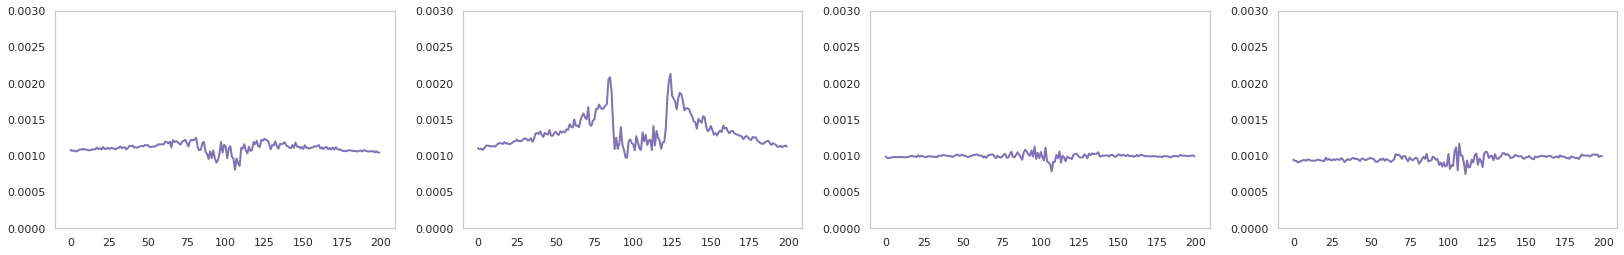

In [9]:
def plot_tracks(pred_unplug_bias, ax=None, ylim=0.01, start=500-100+5, end=500+100+5 ):
    width = end - start
    ax.plot(range(width), pred_unplug_bias[:, start:end].mean(0), 'm', linewidth=2)
    ax.set_ylim(0,ylim)   

    #plt.legend()


import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (28,4)
fig, axs = plt.subplots(1, 4)
i=0
#ylims=[0.005,0.025,0.025,0.025, 0.025] 
ylims=[0.009,0.002,0.01,0.01] 
#ylims=[0.02,0.0175]
ylims=[0.002,0.002,0.002,0.002, 0.002] 
#ylims=[0.025, 0.025]
#ylims=[0.009,0.005,0.02,0.009] 
#ylims=[0.009,0.002,0.01,0.01] 
#ylims=[0.009,0.005,0.02,0.009] 
#ylims=[0.02,0.02] 
ylims=[0.003,0.003,0.003,0.003] 

for pred_unplug_bias in predictions_motifs:
    plot_tracks(np.array(pred_unplug_bias).reshape(num,1000), axs[i], ylims[i])
    i+=1
    
plt.show()




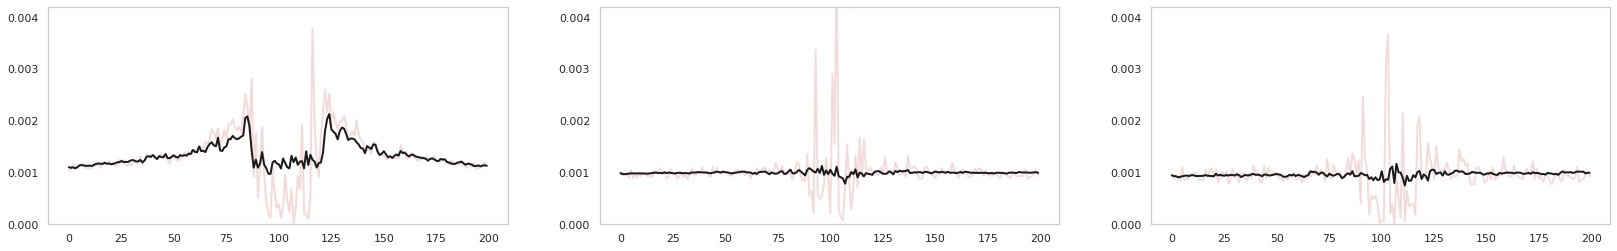

In [13]:
#import pickle as pkl
#pkl.dump(predictions_motifs, open("gm12878_bias.pkl", "wb"))
import pickle as pkl

pkl.dump(predictions_motifs, open("gm12878_corrected.pkl", "wb"))
data_n = pkl.load( open("gm12878_bias.pkl", "rb"))

def plot_tracks(pred_bias,pred_unplug_bias, ax=None, ylim=0.01, start=500-100+5, end=500+100+5 ):
    width = end - start
    ax.plot(range(width), pred_bias[:, start:end].mean(0), 'r', linewidth=2, alpha=0.2, label="uncorrected")
    ax.plot(range(width), pred_unplug_bias[:, start:end].mean(0), 'k', linewidth=2, label="corrected")
    ax.set_ylim(0,ylim)  
    ax.yaxis.set_ticks(np.arange(0, 0.0041, 0.001))

    #ax.legend()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (28,4)
fig, axs = plt.subplots(1, 3)
ylims=[0.0042,0.0042,0.0042,0.0042] 
i=1
for pred_unplug_bias in predictions_motifs:
    if i==4:
        break
    plot_tracks(np.array(data_n[i]).reshape(num,1000), np.array(predictions_motifs[i]).reshape(num,1000), axs[i-1], ylims[i-1])
    i+=1

plt.show()

